# Qubit Nerual Network

__Qubit neural network and its learning efficiency__  
DOI 10.1007/s00521-004-0446-8

The following notebook demonstates the implementation and performance of the neural network that utilizes the qubit neurons as its layers elements.  
The model was tested using test dataset.

## Qubit neuron diagram

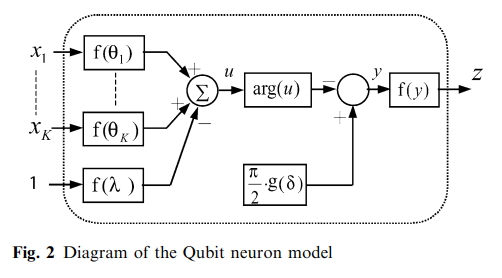

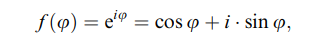

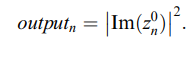

## Implementation

### Init and helper functions

In [1]:
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
from mxnet.gluon import HybridBlock
from mxnet.gluon import Parameter

import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_weights(layer_name):
    #region Extract weights
    array = net.collect_params()[layer_name].data(ctx=ctx).asnumpy()
    first_dim = int(np.sqrt(array.shape[0]))
    second_dim = array.shape[1]

    imgs = []
    for i in range(second_dim):
        imgs.append(array.reshape((first_dim, first_dim, second_dim))[:,:,i])
    #endregion
    
    #region Plotting
    n_col = 5 if second_dim % 5 == 0 else 8
    n_row = math.floor(second_dim / n_col) if second_dim % n_col == 0 else math.ceil(second_dim / n_col)

    _, axs = plt.subplots(n_row, n_col, figsize = (16, 16))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img, cmap = 'gray')
    #endregion

In [3]:
def print_progress(idx, final_idx, min_step = 1):
    min_step = min_step if min_step <= final_idx else final_idx
    if idx % (final_idx // 100 * min_step) == 0: print("%.0f%% done" % (idx / final_idx * 100), end='\r')

In [4]:
def evaluate_accuracy(data_iterator, net):
    metric = mx.metric.Accuracy()
    numerator = 0.
    denominator = 0.

    for i, (data, label) in enumerate(data_iterator):
        with autograd.record():
            data = data.as_in_context(ctx).reshape((-1, 784))
            label = label.as_in_context(ctx)
            label_one_hot = nd.one_hot(label, 10)
            output = net(data)

        metric.update([label], [output])
    return metric.get()[1]

In [5]:
mx.random.seed(42)
batch_size = 100

def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

In [6]:
ctx = mx.gpu(1) if mx.context.num_gpus() > 0 else mx.cpu(0)

### Model definition

In [7]:
def relu(X):
    return nd.maximum(X, 0)

def sigmoid(X):
    return 1 / (1 + nd.exp(-X))

def linear(X):
    return X

In [8]:
class BaselineDenseLayer(HybridBlock):
    def __init__(self, units, in_units = 0, **kwargs):
        super(BaselineDenseLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.units = units
            self._in_units = in_units
            self.weight = self.params.get(
                'weight', init=mx.init.Xavier(magnitude=2.24),
                shape=(in_units, units))
            self.bias = self.params.get('bias', shape=(units,))

    def forward(self, x):
        with x.context:
            linear = nd.dot(x, self.weight.data()) + self.bias.data()
            activation = relu(linear)
            return activation

In [9]:
class QubitPhaseLimitLayer(HybridBlock):
    def __init__(self, **kwargs):
        super(QubitPhaseLimitLayer, self).__init__(**kwargs)

    def forward(self, x):
        x_max = nd.max(x, axis = 1)
        normalized = (x.T / x_max).T
        half_pi_normalized = normalized * np.pi / 2
        
        return half_pi_normalized
    
class QubitProbabilityLayer(HybridBlock):
    def __init__(self, **kwargs):
        super(QubitProbabilityLayer, self).__init__(**kwargs)    
    
    def forward(self, x):
        im = nd.sin(x)
        squared_im = nd.square(im)
        
        return squared_im

In [10]:
class QubitComplexLayer(HybridBlock):
    def __init__(self, in_units, out_units, **kwargs):
        super(QubitComplexLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.in_units = in_units
            self.out_units = out_units
            self.magnitude = 1

            # m x n
            self.theta_re = self.params.get(
                'theta_re', init = mx.init.Xavier(magnitude = self.magnitude),
                shape = (self.in_units, self.out_units))
            self.theta_im = self.params.get(
                'theta_im', init = mx.init.Xavier(magnitude = self.magnitude),
                shape = (self.in_units, self.out_units))

            # n x 1
            self.lambda_re = self.params.get('lambda_re', shape = (self.out_units,))
            self.lambda_im = self.params.get('lambda_im', shape = (self.out_units,))

            # 1 x 1
            self.delta = self.params.get('delta', shape = (self.out_units,))
        
    def get_re_im_from_fi(self, fi):
        re = nd.cos(fi)
        im = nd.sin(fi)
        return re, im
    

    def forward(self, fi_in):
        # k x m
        x_re, x_im = self.get_re_im_from_fi(fi_in)
        
        theta_re = self.theta_re.data()
        theta_im = self.theta_im.data()
        lambda_re = self.lambda_re.data()
        lambda_im = self.lambda_im.data()
        delta = self.delta.data()
        
        # k x n             # k x m  # m x n
        x_re_theta_re = nd.dot(x_re, theta_re)
        x_re_theta_im = nd.dot(x_re, theta_im)
        x_im_theta_re = nd.dot(x_im, theta_re)
        x_im_theta_im = nd.dot(x_im, theta_im)
        
        # k x n
        x_theta_re = x_re_theta_re - x_im_theta_im
        x_theta_im = x_re_theta_im + x_im_theta_re
        
        # k x n            # n x 1
        u_re = x_theta_re - lambda_re
        u_im = x_theta_im - lambda_im
        
        # k x n
        arg = nd.arctan(u_im / u_re)
        
        # n x 1
        sigma = (np.pi / 2) * sigmoid(delta)
        
        # k x n
        y = -arg + sigma
        
        # k x n
        fi_out = y
        
        # k x n
        activation = linear(fi_out)
        return activation

In [11]:
class QubitPhaseOnlyLayer(HybridBlock):
    def __init__(self, in_units, out_units, **kwargs):
        super(QubitPhaseOnlyLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.in_units = in_units
            self.out_units = out_units
            self.magnitude = np.pi / 2

            # m x n
            self.theta_fi = self.params.get(
                'theta_fi', init = mx.init.Xavier(magnitude = self.magnitude),
                shape = (self.in_units, self.out_units))

            # n x 1
            self.lambda_fi = self.params.get('lambda_fi', shape = (self.out_units,))

            # 1 x 1
            self.delta = self.params.get('delta', shape = (self.out_units,))
        
    def get_re_im_from_fi(self, fi):
        re = nd.cos(fi)
        im = nd.sin(fi)
        return re, im
    

    def forward(self, fi_in):        
        theta_fi = self.theta_fi.data()
        lambda_fi = self.lambda_fi.data()
        delta = self.delta.data()
        
        # k x m
        x_re, x_im = self.get_re_im_from_fi(fi_in)
        theta_re, theta_im = self.get_re_im_from_fi(theta_fi)
        lambda_re, lambda_im = self.get_re_im_from_fi(lambda_fi)
        
        # k x n             # k x m  # m x n
        x_re_theta_re = nd.dot(x_re, theta_re)
        x_re_theta_im = nd.dot(x_re, theta_im)
        x_im_theta_re = nd.dot(x_im, theta_re)
        x_im_theta_im = nd.dot(x_im, theta_im)
        
        # k x n
        x_theta_re = x_re_theta_re - x_im_theta_im
        x_theta_im = x_re_theta_im + x_im_theta_re
        
        # k x n            # n x 1
        u_re = x_theta_re - lambda_re
        u_im = x_theta_im - lambda_im
        
        # k x n
        arg = nd.arctan(u_im / u_re)
        
        # n x 1
        sigma = (np.pi / 2) * sigmoid(delta)
        
        # k x n
        y = -arg + sigma
        
        # k x n
        fi_out = y
        
        # k x n
        activation = linear(fi_out)
        return activation

### Train test helper functions

In [12]:
def train_net(net):
    net.collect_params().initialize(ctx=ctx)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

    moving_loss = 0.

    test_accuracy_list = []
    for e in range(epochs):
        for i, (data, label) in enumerate(train_data):
            print_progress(i, len(train_data))

            data = data.as_in_context(ctx).reshape((-1, 784))
            label = label.as_in_context(ctx)

            with autograd.record():
                output = net(data)
                cross_entropy = loss(output, label)
                cross_entropy.backward()
            trainer.step(data.shape[0])

        test_accuracy = evaluate_accuracy(test_data, net)
        train_accuracy = evaluate_accuracy(train_data, net)
        test_accuracy_list.append(float(test_accuracy))
        print("Epoch %s. Train_acc %s, Test_acc %s" % (e, train_accuracy, test_accuracy))
    return test_accuracy_list

def test_net(get_net):
    runs_test_accuracy_list = []
    for run in range(number_of_runs_per_net):
        net = get_net()
        runs_test_accuracy_list.append(train_net(net))
    return runs_test_accuracy_list
    
def show_runs_accuracy(runs_test_accuracy_list):
    for run_test_accuracy in runs_test_accuracy_list:
        plt.plot(range(epochs), run_test_accuracy)
    plt.show()
    
def test_and_visualize_for_net(get_net):
    runs_test_accuracy_list = test_net(get_net)
    show_runs_accuracy(runs_test_accuracy_list)

In [13]:
def get_dense_net():
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(BaselineDenseLayer(128, in_units=784))
        net.add(BaselineDenseLayer(64, in_units=128))
        net.add(BaselineDenseLayer(10, in_units=64))
    return net

In [14]:
def get_qubit_complex_net():
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(QubitPhaseLimitLayer())
        net.add(QubitComplexLayer(784, 128))
        net.add(QubitComplexLayer(128, 64))
        net.add(QubitComplexLayer(64, 10))
        net.add(QubitProbabilityLayer())
    return net

In [15]:
def get_qubit_phase_only_net():
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(QubitPhaseLimitLayer())
        net.add(QubitPhaseOnlyLayer(784, 128))
        net.add(QubitPhaseOnlyLayer(128, 64))
        net.add(QubitPhaseOnlyLayer(64, 10))
        net.add(QubitProbabilityLayer())
    return net

### Tests

#### The tunable parameters found to be more suitable:  
* Softmax, not L2 loss
* lr at around 0.1
* More shallow or deep nets does not influence the performance in a good way drastically

In [16]:
epochs = 100
number_of_runs_per_net = 3

#### Baseline Dense

Epoch 0. Train_acc 0.8410333333333333, Test_acc 0.8427
Epoch 1. Train_acc 0.94765, Test_acc 0.9449
Epoch 2. Train_acc 0.9639666666666666, Test_acc 0.959
Epoch 3. Train_acc 0.9704666666666667, Test_acc 0.9648
Epoch 4. Train_acc 0.9756333333333334, Test_acc 0.9674
Epoch 5. Train_acc 0.9808333333333333, Test_acc 0.9707
Epoch 6. Train_acc 0.9831333333333333, Test_acc 0.9716
Epoch 7. Train_acc 0.9863833333333333, Test_acc 0.9751
Epoch 8. Train_acc 0.9878666666666667, Test_acc 0.9766
Epoch 9. Train_acc 0.9881333333333333, Test_acc 0.9765
Epoch 10. Train_acc 0.9908166666666667, Test_acc 0.9767
Epoch 11. Train_acc 0.9918666666666667, Test_acc 0.9762
Epoch 12. Train_acc 0.9931666666666666, Test_acc 0.9789
Epoch 13. Train_acc 0.9941666666666666, Test_acc 0.9776
Epoch 14. Train_acc 0.9962166666666666, Test_acc 0.9786
Epoch 15. Train_acc 0.99285, Test_acc 0.9762
Epoch 16. Train_acc 0.9963, Test_acc 0.9775
Epoch 17. Train_acc 0.9974333333333333, Test_acc 0.9792
Epoch 18. Train_acc 0.99745, Test_acc

Epoch 64. Train_acc 0.9999333333333333, Test_acc 0.98
Epoch 65. Train_acc 0.9999333333333333, Test_acc 0.9799
Epoch 66. Train_acc 0.9999333333333333, Test_acc 0.9805
Epoch 67. Train_acc 0.9999333333333333, Test_acc 0.9802
Epoch 68. Train_acc 0.9999333333333333, Test_acc 0.9804
Epoch 69. Train_acc 0.9999333333333333, Test_acc 0.9805
Epoch 70. Train_acc 0.9999333333333333, Test_acc 0.9802
Epoch 71. Train_acc 0.9999333333333333, Test_acc 0.9806
Epoch 72. Train_acc 0.9999333333333333, Test_acc 0.9801
Epoch 73. Train_acc 0.9999333333333333, Test_acc 0.9799
Epoch 74. Train_acc 0.9999333333333333, Test_acc 0.9805
Epoch 75. Train_acc 0.9999333333333333, Test_acc 0.9803
Epoch 76. Train_acc 0.9999333333333333, Test_acc 0.9804
Epoch 77. Train_acc 0.9999333333333333, Test_acc 0.9798
Epoch 78. Train_acc 0.9999333333333333, Test_acc 0.9802
Epoch 79. Train_acc 0.9999333333333333, Test_acc 0.9801
Epoch 80. Train_acc 0.9999333333333333, Test_acc 0.9801
Epoch 81. Train_acc 0.9999333333333333, Test_acc 0

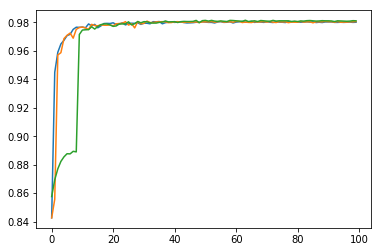

In [17]:
test_and_visualize_for_net(get_dense_net)

<center>~98%</center>

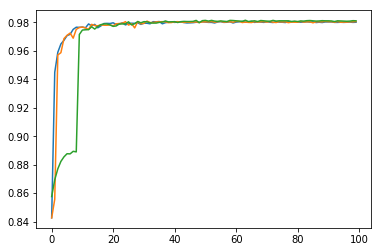

#### Qubit Net with Im and Re as separate training parameters
(that means that complex number is not normalized to the unit length)

Epoch 0. Train_acc 0.4066, Test_acc 0.4028
Epoch 1. Train_acc 0.5276833333333333, Test_acc 0.5267
Epoch 2. Train_acc 0.54825, Test_acc 0.5507
Epoch 3. Train_acc 0.5170833333333333, Test_acc 0.5095
Epoch 4. Train_acc 0.5708666666666666, Test_acc 0.5662
Epoch 5. Train_acc 0.6235666666666667, Test_acc 0.6312
Epoch 6. Train_acc 0.6350166666666667, Test_acc 0.6436
Epoch 7. Train_acc 0.5451666666666667, Test_acc 0.5468
Epoch 8. Train_acc 0.5546833333333333, Test_acc 0.5577
Epoch 9. Train_acc 0.6447666666666667, Test_acc 0.653
Epoch 10. Train_acc 0.6915, Test_acc 0.7001
Epoch 11. Train_acc 0.6968833333333333, Test_acc 0.7001
Epoch 12. Train_acc 0.73165, Test_acc 0.7308
Epoch 13. Train_acc 0.6251666666666666, Test_acc 0.6271
Epoch 14. Train_acc 0.7217333333333333, Test_acc 0.7259
Epoch 15. Train_acc 0.67875, Test_acc 0.6863
Epoch 16. Train_acc 0.70595, Test_acc 0.7057
Epoch 17. Train_acc 0.78095, Test_acc 0.7854
Epoch 18. Train_acc 0.7647333333333334, Test_acc 0.7667
Epoch 19. Train_acc 0.7244

Epoch 59. Train_acc 0.8347333333333333, Test_acc 0.8308
Epoch 60. Train_acc 0.8305333333333333, Test_acc 0.8323
Epoch 61. Train_acc 0.8658666666666667, Test_acc 0.8671
Epoch 62. Train_acc 0.8444166666666667, Test_acc 0.8411
Epoch 63. Train_acc 0.8563, Test_acc 0.8568
Epoch 64. Train_acc 0.8833, Test_acc 0.8819
Epoch 65. Train_acc 0.8784333333333333, Test_acc 0.8806
Epoch 66. Train_acc 0.88275, Test_acc 0.885
Epoch 67. Train_acc 0.8849166666666667, Test_acc 0.8868
Epoch 68. Train_acc 0.8971833333333333, Test_acc 0.9001
Epoch 69. Train_acc 0.89255, Test_acc 0.892
Epoch 70. Train_acc 0.8907, Test_acc 0.8891
Epoch 71. Train_acc 0.8952666666666667, Test_acc 0.8913
Epoch 72. Train_acc 0.9044833333333333, Test_acc 0.9067
Epoch 73. Train_acc 0.9024166666666666, Test_acc 0.9063
Epoch 74. Train_acc 0.8841666666666667, Test_acc 0.8824
Epoch 75. Train_acc 0.9101666666666667, Test_acc 0.9105
Epoch 76. Train_acc 0.8938166666666667, Test_acc 0.8901
Epoch 77. Train_acc 0.9209666666666667, Test_acc 0.9

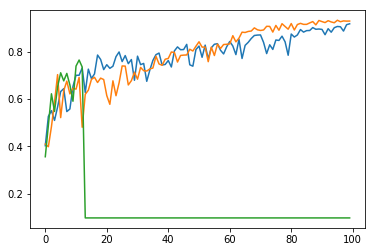

In [18]:
test_and_visualize_for_net(get_qubit_complex_net)

<center>~92%</center>

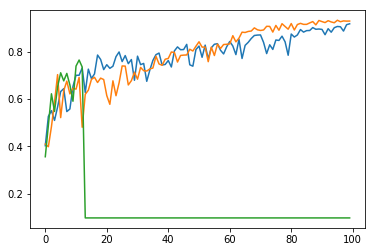

#### Qubit Phase Only Net
(unit length number, original configuration of the paper)

Epoch 0. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 1. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 2. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 3. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 4. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 5. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 6. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 7. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 8. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 9. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 10. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 11. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 12. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 13. Train_acc 0.11236666666666667, Test_acc 0.1135
Epoch 14. Train_acc 0.11238333333333334, Test_acc 0.1135
Epoch 15. Train_acc 0.11238333333333334, Test_acc 0.1135
Epoch 16. Train_acc 0.11238333333333334, Test_acc 0.1135
Epoch 17. Train_acc 0.11243333333333333, 

Epoch 54. Train_acc 0.15353333333333333, Test_acc 0.151
Epoch 55. Train_acc 0.15211666666666668, Test_acc 0.1495
Epoch 56. Train_acc 0.15301666666666666, Test_acc 0.1498
Epoch 57. Train_acc 0.15188333333333334, Test_acc 0.1493
Epoch 58. Train_acc 0.15196666666666667, Test_acc 0.1493
Epoch 59. Train_acc 0.15181666666666666, Test_acc 0.1493
Epoch 60. Train_acc 0.15226666666666666, Test_acc 0.1495
Epoch 61. Train_acc 0.15293333333333334, Test_acc 0.1498
Epoch 62. Train_acc 0.15086666666666668, Test_acc 0.1485
Epoch 63. Train_acc 0.15083333333333335, Test_acc 0.1485
Epoch 64. Train_acc 0.15325, Test_acc 0.1506
Epoch 65. Train_acc 0.15143333333333334, Test_acc 0.149
Epoch 66. Train_acc 0.15343333333333334, Test_acc 0.1506
Epoch 67. Train_acc 0.15331666666666666, Test_acc 0.1506
Epoch 68. Train_acc 0.15293333333333334, Test_acc 0.1498
Epoch 69. Train_acc 0.15291666666666667, Test_acc 0.1498
Epoch 70. Train_acc 0.15271666666666667, Test_acc 0.1497
Epoch 71. Train_acc 0.1521, Test_acc 0.1495
E

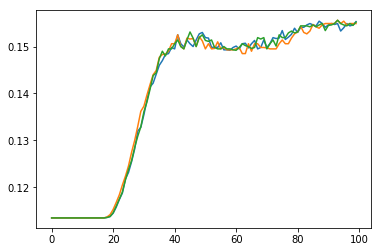

In [19]:
test_and_visualize_for_net(get_qubit_phase_only_net)

<center>~15%</center>

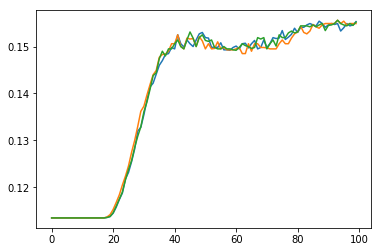

## Weights visualization

In [20]:
# net.collect_params()

In [21]:
# plot_weights('hybridsequential0_qubitlayer0_theta_re')

In [22]:
# plot_weights('hybridsequential0_qubitlayer0_theta_im')

### --magnitude_2.24__--ephochs_100_--layers_3_medium_--net_QubitComplex

### hybridsequential0_qubitlayer0_theta_re
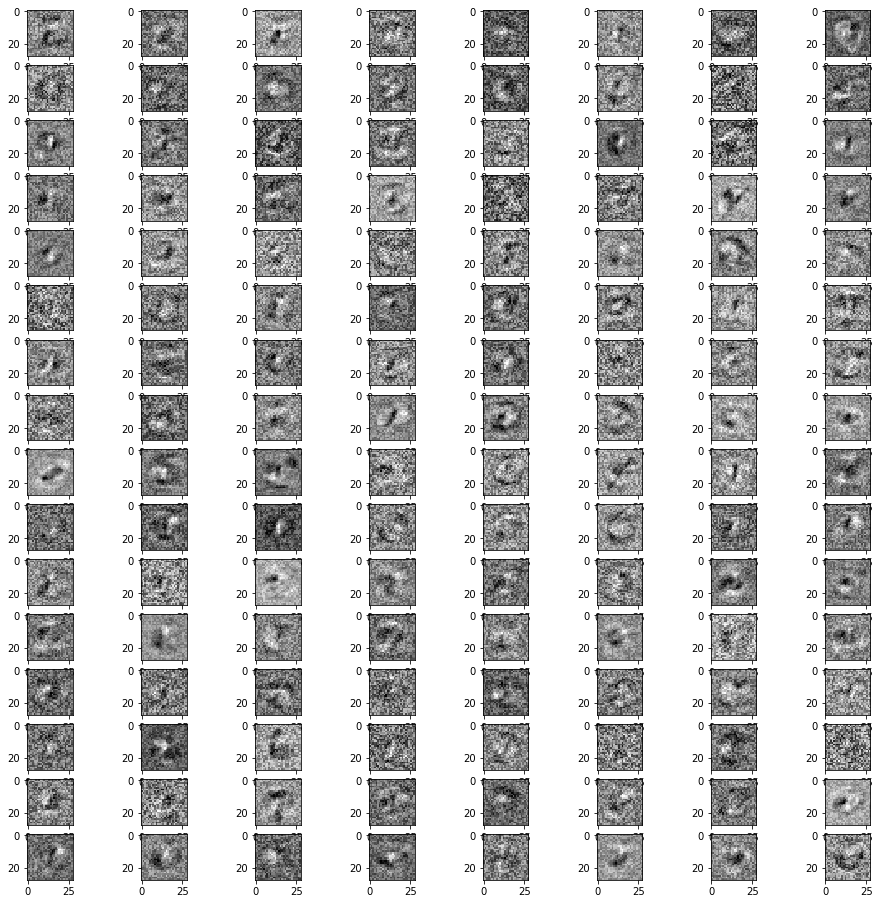

### hybridsequential0_qubitlayer0_theta_im
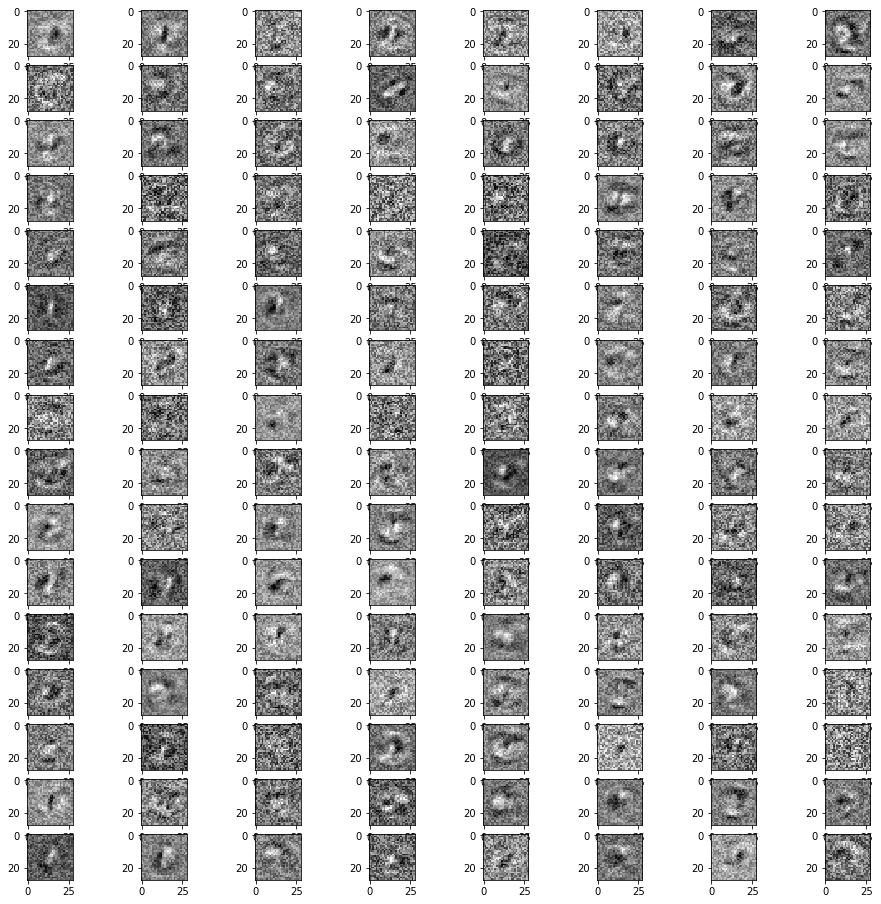

### hybridsequential0_qubitlayer2_theta_re
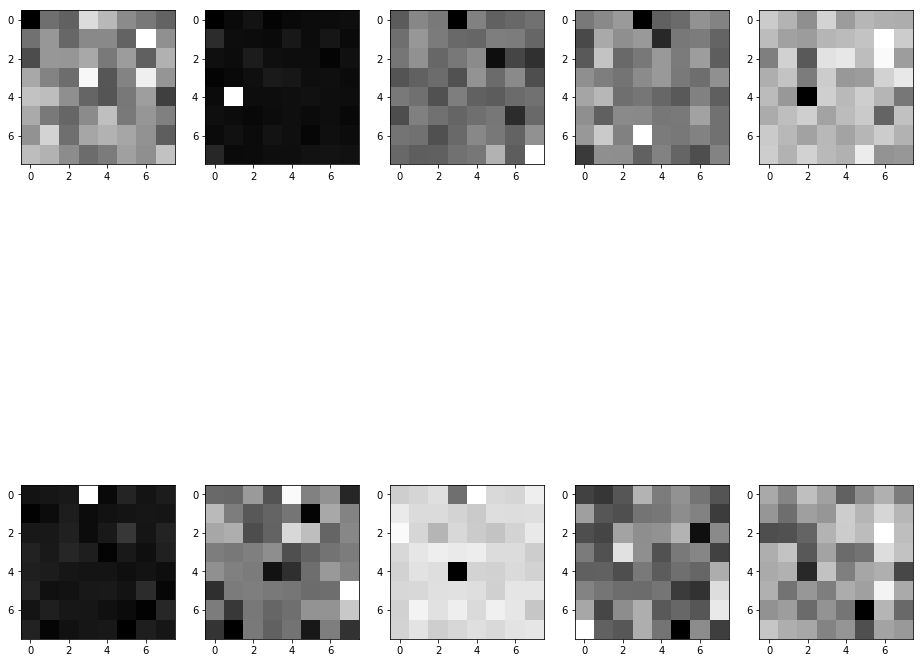

### hybridsequential0_qubitlayer2_theta_im
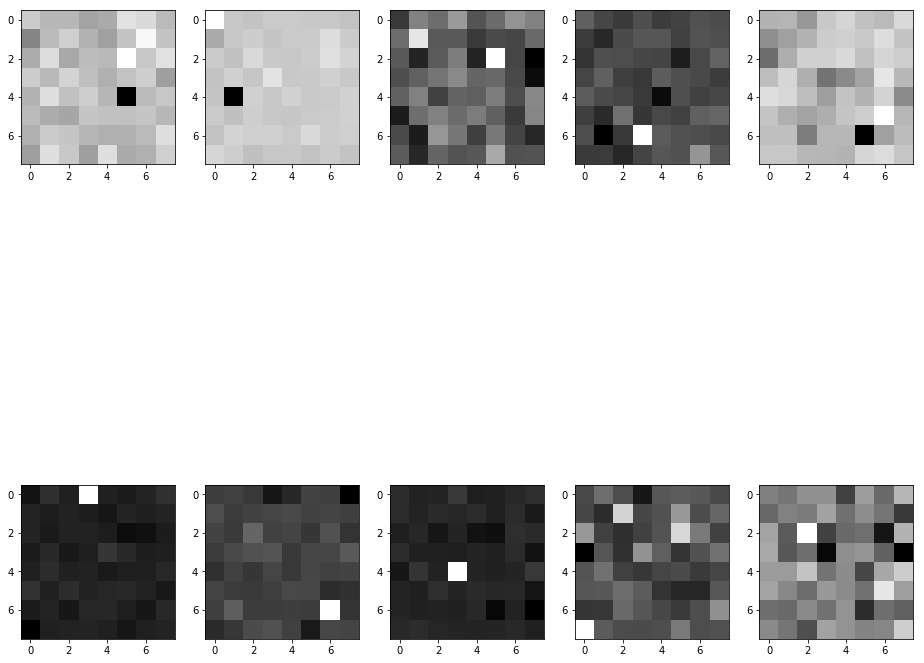